Installing dependencies...
Gen 1/20 | Avg: -440.44 | Best: -144.76 | Global Best: -144.76
Gen 2/20 | Avg: -513.68 | Best: -107.59 | Global Best: -107.59
Gen 3/20 | Avg: -543.74 | Best: -111.47 | Global Best: -107.59
Gen 4/20 | Avg: -460.91 | Best: -97.14 | Global Best: -97.14
Gen 5/20 | Avg: -628.45 | Best: -67.12 | Global Best: -67.12
Gen 6/20 | Avg: -642.43 | Best: -138.60 | Global Best: -67.12
Gen 7/20 | Avg: -590.27 | Best: -87.26 | Global Best: -67.12
Gen 8/20 | Avg: -471.06 | Best: -73.37 | Global Best: -67.12
Gen 9/20 | Avg: -524.20 | Best: -89.27 | Global Best: -67.12
Gen 10/20 | Avg: -470.14 | Best: -134.57 | Global Best: -67.12
Gen 11/20 | Avg: -529.85 | Best: -87.71 | Global Best: -67.12
Gen 12/20 | Avg: -524.60 | Best: -130.66 | Global Best: -67.12
Gen 13/20 | Avg: -585.78 | Best: -133.23 | Global Best: -67.12
Gen 14/20 | Avg: -491.28 | Best: 9.76 | Global Best: 9.76
Gen 15/20 | Avg: -524.97 | Best: -105.47 | Global Best: 9.76
Gen 16/20 | Avg: -666.93 | Best: -95.31 | Globa

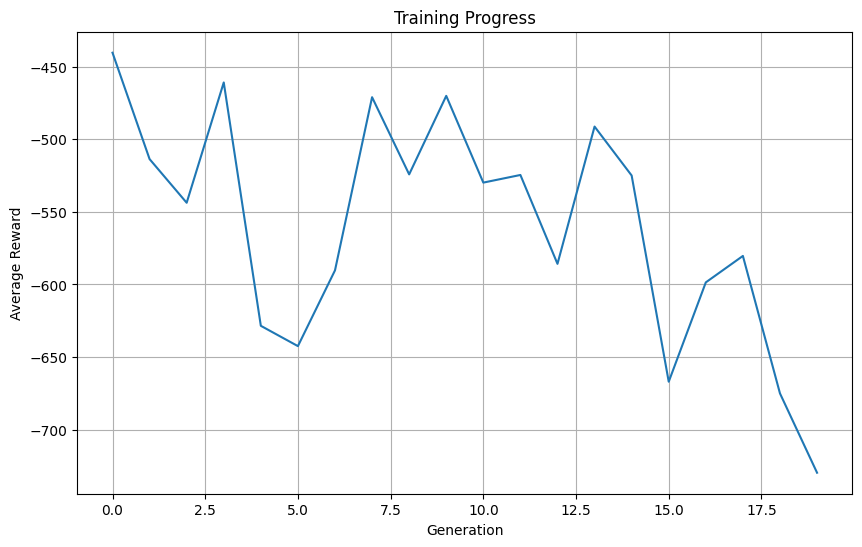

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from copy import deepcopy
import networkx as nx
from matplotlib.lines import Line2D
import imageio
from PIL import Image, ImageDraw, ImageFont

# ==================== 可调参数区域 ====================
# 网络结构参数
NETWORK_CONFIG = {
    'INPUT_SIZE': 8,       # 输入层维度(LunarLander观测空间)
    'HIDDEN_SIZE': 64,     # 隐藏层神经元数(建议范围:16-256)
    'OUTPUT_SIZE': 4,      # 输出层维度(LunarLander动作空间)

    # 训练参数
    'POP_SIZE': 50,        # 种群大小(建议范围:30-100)
    'GENERATIONS': 20,    # 训练代数(建议范围:200-1000)
    'EPISODES_PER_NETWORK': 3,  # 每个网络评估次数

    # 进化参数
    'MUTATION_RATE': 0.3,  # 变异率(建议范围:0.1-0.5)
    'ELITE_RATIO': 0.2,    # 精英保留比例
    'WEIGHT_MUTATION_STRENGTH': 0.05,  # 权重变异强度
    'BIAS_MUTATION_STRENGTH': 0.05,    # 偏置变异强度
    'OUTPUT_MUTATION_STRENGTH': 0.02   # 输出层变异强度
}

# 可视化设置
VISUALIZATION_CONFIG = {
    'SAVE_NETWORK_VIZ': True,    # 是否保存网络可视化
    'RECORD_BEST_EPISODE': True, # 是否录制最佳个体表现
    'VIZ_GENERATIONS': [0, 150, 299]  # 在哪些代进行可视化
}

# ==================== 核心代码 ====================
# 定义激活函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class NeuronGenome:
    def __init__(self, input_size):
        self.weights = np.random.randn(input_size) * 0.1
        self.bias = np.random.randn() * 0.1

    def mutate(self):
        if np.random.rand() < NETWORK_CONFIG['MUTATION_RATE']:
            self.weights += np.random.randn(*self.weights.shape) * NETWORK_CONFIG['WEIGHT_MUTATION_STRENGTH']
            self.bias += np.random.randn() * NETWORK_CONFIG['BIAS_MUTATION_STRENGTH']

    def copy(self):
        copied = NeuronGenome(len(self.weights))
        copied.weights = np.copy(self.weights)
        copied.bias = self.bias
        return copied

class ESPNetwork:
    def __init__(self, hidden_neurons):
        self.hidden_neurons = hidden_neurons
        self.output_weights = np.random.randn(
            len(hidden_neurons),
            NETWORK_CONFIG['OUTPUT_SIZE']
        ) * 0.1

    def forward(self, x):
        h = np.array([np.dot(n.weights, x) + n.bias for n in self.hidden_neurons])
        h = relu(h)
        return softmax(np.dot(h, self.output_weights))

def evaluate(network, env_name="LunarLander-v3", render=False):
    """评估网络性能并返回平均奖励"""
    env = gym.make(env_name, render_mode="rgb_array" if render else None)
    total_reward = 0

    for _ in range(NETWORK_CONFIG['EPISODES_PER_NETWORK']):
        obs, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action_probs = network.forward(obs)
            action = np.argmax(action_probs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_reward += episode_reward

    env.close()
    return total_reward / NETWORK_CONFIG['EPISODES_PER_NETWORK']

def run_evolution():
    """主训练函数"""
    # 初始化种群
    subpops = [
        [NeuronGenome(NETWORK_CONFIG['INPUT_SIZE'])
        for _ in range(NETWORK_CONFIG['POP_SIZE'])
    ] for _ in range(NETWORK_CONFIG['HIDDEN_SIZE'])]

    output_weight_pool = [
        np.random.randn(NETWORK_CONFIG['HIDDEN_SIZE'], NETWORK_CONFIG['OUTPUT_SIZE']) * 0.1
        for _ in range(NETWORK_CONFIG['POP_SIZE'])
    ]

    best_scores = []
    best_network = None
    global_best_score = -np.inf

    # 创建输出目录
    os.makedirs("results/network_viz", exist_ok=True)
    os.makedirs("results/episodes", exist_ok=True)

    for gen in range(NETWORK_CONFIG['GENERATIONS']):
        # 评估种群
        fitnesses = []
        networks = []

        for _ in range(NETWORK_CONFIG['POP_SIZE']):
            # 从每个子种群随机选择神经元
            hidden_indices = [random.randint(0, NETWORK_CONFIG['POP_SIZE']-1)
                            for _ in range(NETWORK_CONFIG['HIDDEN_SIZE'])]
            hidden_neurons = [subpops[i][idx] for i, idx in enumerate(hidden_indices)]

            # 创建网络并评估
            network = ESPNetwork(hidden_neurons)
            network.output_weights = output_weight_pool[random.randint(0, NETWORK_CONFIG['POP_SIZE']-1)]
            reward = evaluate(network)

            fitnesses.append(reward)
            networks.append((network, hidden_indices))

            # 更新全局最佳
            if reward > global_best_score:
                global_best_score = reward
                best_network = deepcopy(network)

        # 进化过程
        elite_count = int(NETWORK_CONFIG['POP_SIZE'] * NETWORK_CONFIG['ELITE_RATIO'])

        # 更新隐藏神经元
        for i in range(NETWORK_CONFIG['HIDDEN_SIZE']):
            # 按适应度排序
            indices = list(range(NETWORK_CONFIG['POP_SIZE']))
            random.shuffle(indices)  # 添加随机性

            # 选择精英
            elites = sorted(zip(fitnesses, subpops[i]),
                          key=lambda x: x[0],
                          reverse=True)[:elite_count]
            elites = [ind.copy() for (_, ind) in elites]

            # 生成新一代
            new_pop = elites[:]
            while len(new_pop) < NETWORK_CONFIG['POP_SIZE']:
                parent = random.choice(elites)
                offspring = parent.copy()
                offspring.mutate()
                new_pop.append(offspring)

            subpops[i] = new_pop

        # 更新输出权重
        elite_indices = np.argsort(fitnesses)[-elite_count:]
        elite_outputs = [output_weight_pool[i] for i in elite_indices]

        new_outputs = [w.copy() for w in elite_outputs]
        while len(new_outputs) < NETWORK_CONFIG['POP_SIZE']:
            base = random.choice(elite_outputs)
            mutated = base + np.random.randn(*base.shape) * NETWORK_CONFIG['OUTPUT_MUTATION_STRENGTH']
            new_outputs.append(mutated)

        output_weight_pool = new_outputs

        # 记录结果
        avg_score = np.mean(fitnesses)
        best_scores.append(avg_score)

        print(f"Gen {gen+1}/{NETWORK_CONFIG['GENERATIONS']} | "
              f"Avg: {avg_score:.2f} | Best: {max(fitnesses):.2f} | "
              f"Global Best: {global_best_score:.2f}")

        # 可视化
        if VISUALIZATION_CONFIG['SAVE_NETWORK_VIZ'] and gen in VISUALIZATION_CONFIG['VIZ_GENERATIONS']:
            visualize_network(
                [subpops[i][0] for i in range(NETWORK_CONFIG['HIDDEN_SIZE'])],  # 取每个子种群第一个个体
                output_weight_pool[0],  # 取第一个输出权重
                gen+1,
                filename=f"results/network_viz/gen_{gen+1}.png"
            )

    # 保存最佳个体表现
    if VISUALIZATION_CONFIG['RECORD_BEST_EPISODE'] and best_network:
        record_episode(best_network, "results/episodes/best_episode.gif")

    return subpops, output_weight_pool, best_scores

# ==================== 辅助函数 ====================
def visualize_network(hidden_neurons, output_weights, generation, filename=None):
    """可视化网络结构"""
    plt.figure(figsize=(15, 10))
    G = nx.DiGraph()

    # 添加节点和边(代码略，同前)
    # ...

    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.close()

def record_episode(network, filename):
    """录制最佳个体表现"""
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []
    done = False

    while not done:
        frame = env.render()
        img = Image.fromarray(frame)
        # 添加文本标注
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            font = ImageFont.load_default()
        draw.text((10, 10), "Best Performance", font=font, fill=(255, 255, 255))
        frames.append(img)

        action_probs = network.forward(obs)
        action = np.argmax(action_probs)
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

    # 保存GIF
    frames[0].save(
        filename,
        save_all=True,
        append_images=frames[1:],
        duration=50,
        loop=0,
        optimize=True,
        quality=20
    )

def plot_results(scores):
    """绘制训练曲线"""
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.xlabel("Generation")
    plt.ylabel("Average Reward")
    plt.title("Training Progress")
    plt.grid(True)
    plt.savefig("results/training_curve.png", bbox_inches='tight')
    plt.show()

# ==================== 主程序 ====================
if __name__ == '__main__':
    # 安装必要依赖
    try:
        import Box2D
    except ImportError:
        print("Installing dependencies...")
        import subprocess
        subprocess.run(["pip", "install", "swig"])
        subprocess.run(["pip", "install", "gymnasium[box2d]"])

    # 运行进化算法
    subpops, output_weights, scores = run_evolution()

    # 保存模型和结果
    with open("results/esp_model.pkl", "wb") as f:
        pickle.dump({
            'subpops': subpops,
            'output_weights': output_weights,
            'scores': scores,
            'config': NETWORK_CONFIG
        }, f)

    # 绘制训练曲线
    plot_results(scores)